# Sistem Rekomendasi pada Buku
Proyek ini bertujuan untuk membangun sistem rekomendasi buku menggunakan pendekatan Collaborative Filtering dengan algoritma SVD (Singular Value Decomposition). Sistem ini dapat memberikan rekomendasi buku kepada pengguna berdasarkan pola interaksi pengguna lain yang memiliki preferensi serupa.

Dataset yang digunakan berasal dari Kaggle: [Book Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset).

- **Nama:** Aura Rachmawaty
- **Email:** mc295d5x1618@student.devacademy.id
- **ID Dicoding:** MC295D5X1618

## 1. Instalasi kaggle API dan setup credentials
Langkah pertama adalah menginstal library `kaggle` dan mengunggah file `kaggle.json` dari akun Kaggle. File ini digunakan untuk autentikasi saat mengunduh dataset langsung dari Kaggle.


In [18]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload file kaggle.json dari akun Kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (2).json


## 2. Download dan ekstrak dataset
Dataset yang digunakan adalah "Book Recommendation Dataset" dari Kaggle. Setelah berhasil diunduh, file ZIP akan diekstrak.


In [19]:
!kaggle datasets download -d arashnic/book-recommendation-dataset
!unzip -q book-recommendation-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
book-recommendation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## 3. Instalasi library tambahan
Untuk menjalankan model Collaborative Filtering, kita menggunakan library pandas, matplotlib, seaborn, `scikit-surprise` dan menyesuaikan versi `numpy` agar kompatibel.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Install
!pip install numpy==1.23.5
!pip install scikit-surprise --no-cache-dir

# Import yang dibutuhkan
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

## 4. Membaca dataset
Dataset terdiri dari tiga file utama: `Books.csv`, `Users.csv`, dan `Ratings.csv`. Dataset dibaca menggunakan pandas dan dikodekan dengan `'latin-1'` karena encoding asli dari file.

In [35]:
books = pd.read_csv('Books.csv', encoding='latin-1', on_bad_lines='skip')
users = pd.read_csv('Users.csv', encoding='latin-1', on_bad_lines='skip')
ratings = pd.read_csv('Ratings.csv', encoding='latin-1', on_bad_lines='skip')

<ipython-input-35-f6c46ab4b572>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv', encoding='latin-1', on_bad_lines='skip')


## 5. Informasi Awal Dataset

Langkah awal dalam proses analisis data adalah memahami ukuran (dimensi) masing-masing dataset. Dengan menggunakan method `.shape`, kita dapat mengetahui jumlah baris dan kolom dari setiap file dataset yang digunakan:

- **Books.csv**: berisi informasi metadata buku seperti judul, penulis, penerbit, dan tahun terbit.
- **Users.csv**: memuat data pengguna seperti ID pengguna, lokasi, dan usia.
- **Ratings.csv**: berisi data interaksi pengguna terhadap buku dalam bentuk rating.

Mengetahui ukuran dataset membantu memahami skala data dan potensi kebutuhan pembersihan atau pengolahan lanjutan. Hal ini juga berguna untuk memperkirakan beban komputasi saat membangun model sistem rekomendasi.


In [24]:
print("Books.csv:", books.shape)
print("Users.csv:", users.shape)
print("Ratings.csv:", ratings.shape)

Books.csv: (271360, 8)
Users.csv: (278858, 3)
Ratings.csv: (1149780, 3)


## 6. Filtering Rating Eksplisit

Pada tahap **filter rating**, kita memfilter hanya rating yang bersifat **eksplisit**, yaitu rating dengan nilai lebih dari 0. Hal ini dilakukan karena dalam dataset ini, nilai 0 sering digunakan sebagai indikasi **tidak memberikan rating** atau **interaksi implisit** yang kurang informatif.

Dengan memfokuskan hanya pada rating eksplisit, sistem rekomendasi dapat belajar dari preferensi pengguna yang benar-benar terukur. Langkah ini juga membantu meningkatkan akurasi model dan mengurangi noise dalam data.

Hasil filter menunjukkan jumlah total interaksi eksplisit yang akan digunakan dalam pemodelan sistem rekomendasi.

In [36]:
ratings_filtered = ratings[ratings['Book-Rating'] > 0]

print("Jumlah rating eksplisit:", len(ratings_filtered))
ratings_filtered.head()

Jumlah rating eksplisit: 433671


,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


## 7. Pembersihan data

- Menghapus rating bernilai 0 karena itu adalah implicit rating.
- Membersihkan missing values pada kolom penting (`Book-Author`, `Publisher`, `Image-URL-L`).
- Membersihkan nilai `Age` yang tidak masuk akal (<5 atau >100).
- Mengisi missing value pada `Age` dengan nilai median.


In [25]:
# Hapus rating 0
ratings_filtered = ratings[ratings['Book-Rating'] > 0]

print("Missing values in Books:")
print(books.isnull().sum())

print("\nMissing values in Users:")
print(users.isnull().sum())

print("\nMissing values in Ratings:")
print(ratings.isnull().sum())

print("\nDuplicate rows:")
print("Books:", books.duplicated().sum())
print("Users:", users.duplicated().sum())
print("Ratings:", ratings.duplicated().sum())

Missing values in Books:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Missing values in Users:
User-ID          0
Location         0
Age         110762
dtype: int64

Missing values in Ratings:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Duplicate rows:
Books: 0
Users: 0
Ratings: 0


## 8. Analisis dan Pembersihan Data Usia Pengguna

Pada tahap ini, dilakukan eksplorasi dan pembersihan terhadap data usia pengguna untuk mengidentifikasi nilai-nilai yang tidak wajar (outlier). Kolom `Age` merupakan bagian penting dari data demografis, namun seringkali mengandung data yang tidak valid seperti usia yang terlalu kecil atau terlalu besar.

Langkah-langkah yang dilakukan:

1. **Statistik Deskriptif Usia**
   - Digunakan fungsi `.describe()` untuk melihat ringkasan statistik seperti mean, min, max, dan kuartil dari data usia pengguna.
   - Ini memberikan gambaran awal apakah terdapat nilai yang mencurigakan.

2. **Visualisasi Distribusi Usia**
   - Histogram dibuat menggunakan `seaborn.histplot()` untuk melihat distribusi usia.
   - Visualisasi ini membantu mengidentifikasi outlier secara visual dan menunjukkan apakah distribusi usia terlihat normal.

3. **Deteksi Outlier**
   - Pengguna dengan usia kurang dari 5 tahun atau lebih dari 100 tahun dianggap sebagai outlier.
   - Nilai-nilai ini kemungkinan merupakan kesalahan input atau data yang tidak valid, sehingga perlu ditinjau lebih lanjut atau dibersihkan.

Tujuan dari langkah ini adalah untuk memastikan bahwa analisis dan model yang akan dibangun tidak terpengaruh oleh data usia yang tidak realistis.

Statistik usia sebelum dibersihkan:
count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64


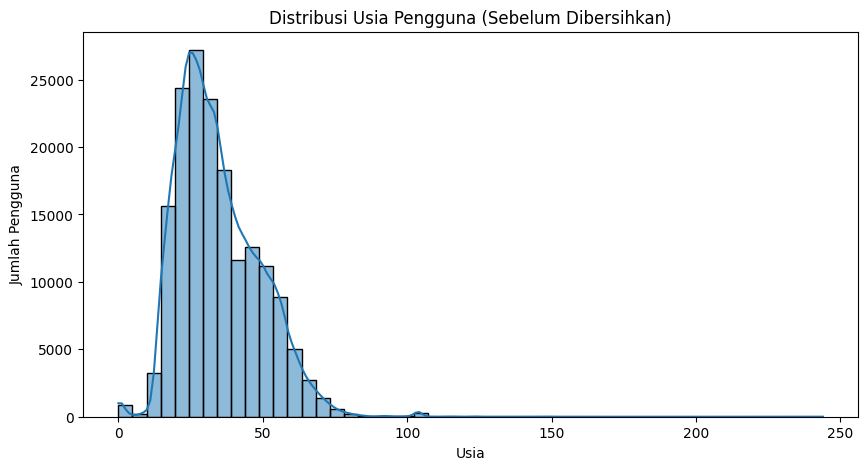


Jumlah pengguna dengan usia outlier: 1248
     User-ID  Age
219      220  0.0
469      470  0.0
561      562  0.0
612      613  1.0
670      671  1.0


In [26]:
# Cek nilai unik usia sebelum dibersihkan
print("Statistik usia sebelum dibersihkan:")
print(users['Age'].describe())

# Visualisasi distribusi usia
plt.figure(figsize=(10, 5))
sns.histplot(users['Age'], bins=50, kde=True)
plt.title('Distribusi Usia Pengguna (Sebelum Dibersihkan)')
plt.xlabel('Usia')
plt.ylabel('Jumlah Pengguna')
plt.show()

# Deteksi outlier usia (kurang dari 5 atau lebih dari 100)
outliers = users[(users['Age'] < 5) | (users['Age'] > 100)]
print(f"\nJumlah pengguna dengan usia outlier: {len(outliers)}")
print(outliers[['User-ID', 'Age']].head())

## 9. Pembersihan Data pada Dataset Books dan Users

Langkah ini bertujuan untuk meningkatkan kualitas data sebelum digunakan dalam proses analisis dan pemodelan. Pembersihan dilakukan dengan menghapus nilai-nilai yang hilang dan memperbaiki data yang tidak valid.

#### a. Pembersihan Dataset **Books**
- Menghapus baris yang memiliki nilai kosong (`NaN`) pada kolom-kolom penting seperti:
  - `Book-Author` → Nama penulis buku
  - `Publisher` → Nama penerbit
  - `Image-URL-L` → URL gambar ukuran besar
- Alasan: Ketiga atribut ini penting untuk keperluan informasi metadata dan visualisasi buku dalam sistem rekomendasi. Kehilangan informasi ini dapat mengganggu pengalaman pengguna.

#### b. Pembersihan Dataset **Users**
- Kolom `Age` dibersihkan dari nilai yang tidak logis:
  - Usia di bawah 5 tahun atau di atas 100 tahun dianggap tidak valid dan diubah menjadi `None`.
- Setelah itu, nilai `None` pada kolom usia diisi dengan **median usia pengguna**.
- Alasan:
  - Menjaga integritas data usia agar tetap realistis.
  - Pengisian median digunakan karena lebih tahan terhadap outlier dibandingkan rata-rata (mean), sehingga memberikan estimasi yang lebih stabil.

Pembersihan ini penting agar data yang digunakan untuk pelatihan model bebas dari noise dan representatif terhadap kondisi nyata.

In [27]:
# Bersihkan Books
books_cleaned = books.dropna(subset=['Book-Author', 'Publisher', 'Image-URL-L'])

# Bersihkan Users
users['Age'] = users['Age'].apply(lambda x: None if x < 5 or x > 100 else x)
users['Age'].fillna(users['Age'].median(), inplace=True)

<ipython-input-27-2150c39b7057>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users['Age'].fillna(users['Age'].median(), inplace=True)


## 10. Pemeriksaan data hilang dan duplikat
Langkah ini untuk mengetahui sejauh mana kualitas data, dengan memeriksa nilai yang hilang dan baris yang duplikat di setiap dataset.

terlihat bahwa data sudah aman, tidak ada missing value ataupun duplikat lagi.


In [28]:
print("Missing values setelah pembersihan:")
print(books_cleaned.isnull().sum())

print("\nMissing values in Users:")
print(users.isnull().sum())

print("\nMissing values in Ratings:")
print(ratings.isnull().sum())

Missing values setelah pembersihan:
ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

Missing values in Users:
User-ID     0
Location    0
Age         0
dtype: int64

Missing values in Ratings:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


## 11. Menggabungkan ratings dengan buku
Gabungkan data `ratings_filtered` dengan data `books_cleaned` berdasarkan `ISBN` untuk mendapatkan informasi buku yang telah diberi rating.


In [29]:
# Gabungkan Ratings dengan Books
ratings_merged = pd.merge(ratings_filtered, books_cleaned, on='ISBN')

## 12. Membangun model Collaborative Filtering (CF) dengan SVD
Menggunakan library `surprise`, kita membuat objek `Reader`, mempersiapkan dataset, melakukan split train-test, dan melatih model SVD (Singular Value Decomposition).


In [30]:
# Gunakan reader dari surprise
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings_merged[['User-ID', 'ISBN', 'Book-Rating']], reader)

# Split train dan test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Training model
model = SVD()
model.fit(trainset)

## 13. Evaluasi model
Model dievaluasi menggunakan metrik RMSE (Root Mean Squared Error) dari prediksi terhadap test set.


In [31]:
# Evaluasi model
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 1.6343


## 14. Fungsi rekomendasi berdasarkan Collaborative Filtering
Fungsi `recommend_books_cf` akan memberikan rekomendasi buku untuk user tertentu berdasarkan prediksi rating tertinggi dari model SVD untuk buku-buku yang belum dirating.


In [32]:
def recommend_books_cf(user_id, num_recommendations=5):
    # Cari ISBN yang belum pernah dirating user tersebut
    rated_books = ratings_filtered[ratings_filtered['User-ID'] == user_id]['ISBN']
    unrated_books = books_cleaned[~books_cleaned['ISBN'].isin(rated_books)]

    # Prediksi rating untuk buku-buku tersebut
    predictions = []
    for _, row in unrated_books.iterrows():
        try:
            est = model.predict(user_id, row['ISBN']).est
            predictions.append((row['Book-Title'], row['Book-Author'], est))
        except:
            continue

    top_predictions = sorted(predictions, key=lambda x: x[2], reverse=True)[:num_recommendations]

    print(f"Rekomendasi untuk User-ID: {user_id}\n")
    return pd.DataFrame(top_predictions, columns=['Book-Title', 'Book-Author', 'Predicted Rating'])

## 15. Menentukan User Sample dan Menampilkan Rekomendasi Buku

Pada tahap ini, kita memilih **User-ID** dari dataset `ratings_filtered` yang telah difilter sebelumnya, kemudian menampilkan rekomendasi buku untuk pengguna tersebut menggunakan metode **Collaborative Filtering**.


In [33]:
user_sample = ratings_filtered['User-ID'].sample(1).values[0]
recommend_books_cf(user_sample)

Rekomendasi untuk User-ID: 84038



,Book-Title,Book-Author,Predicted Rating
0,"My Sister's Keeper : A Novel (Picoult, Jodi)",Jodi Picoult,9.201056
1,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,9.127904
2,Dilbert: A Book of Postcards,Scott Adams,9.114887
3,"Wolves of the Calla (The Dark Tower, Book 5)",Stephen King,9.092526
4,Lonesome Dove,Larry McMurtry,9.087445


NOTE :
pada reviewer sebelumnya menolak laporan saya karena user-id is not defined, tapi terbukti disini bahwa user-id ada pada dataset rating_filtered.

In [34]:
print(ratings_filtered.columns)

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')
